![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Classification kNN

## Mise en situation
Je suis travaille (toujours) pour le bureau de poste. Je dois trouver un (autre) algorithme pour lire les chiffres des codes postaux.

Je cherche un algorithme simple, sans apprentissage, ça existe ça ?

## Les K plus proches voisins
### Les deux pièges de terminologie
L'algorithme _kNN_ pour _K Nearest neighbours_ :
* n'a rien à voir avec les réseaux de neurones (malgré le _NN_ du nom - ça n'est pas Neural Network)
* n'a rien à voir non plus avec l'alogrithme des "K moyens" (ou _k-means_ en anglais)

Voilà, maintenant qu'on a défini ce que ça n'est pas, on va pouvoir se pencher sur ce que c'est.

### L'algorithme en quelques mots
Je dispose d'un jeu de données, ça ça ne change pas, pour classifier d'autres données inconnues. J'en ai une nouvelle justement : dans quelle case la mettre?

L'intuition est la suivante : "est-ce que ma nouvelle donnée ressemble à quelque chose de connu ?". Si oui, c'est (peut-être) un objet de la même classe ! Formulé différement : "La classe que je recherche est celle du _plus proche voisin_ de ma donnée !".

Bon faut être honnête, parfois c'est oui parfois c'est non... Mais en étendant un peu le principe :
* on considère les _k_ plus proches voisins
* on regarde la classe la plus présente dans le lot des _k_ voisins

Ca lisse un peu les erreurs. Et la question qui arrive : "C'est quoi l'arnaque, ça marche un truc pareil ???", on va dire que parfois oui et parfois non aussi...

_Page de publicité : si vous avez raté la saison 1, vous pouvez toujours jeter un oeil à [cet article sur la reconnaissance de gestes](https://www.linkedin.com/pulse/mieux-coder-en-restant-chez-soi-j2-la-de-gestes-david-amar/). Ca marche vraiment, et en plus c'est avec k=1_

### Le choix de _k_
**A supposer que le problème puisse être résolu avec cet algorithme**, le choix de _k_ est important
> Si k est faible, on augmente le risque de tomber sur de "mauvais" voisins qui vont fausser la réponse

Ok, j'ai qu'à prendre un _k_ plus élevé alors. 10, c'est bien :)

Considérons que j'ai maintenant 100 exemples dans mon jeu d'entrainement. k=10, ça veut dire que 10% de mes exemples sont des "plus proches voisins" de l'entrée considerée - c'est un peu gros comme proportion... Et ça dépend aussi du nombre de classes. Si j'ai beaucoup de classes différentes, il me faudra beaucoup de données pour les différencier.

> Si k est élevé, on diminue ce risque **mais** il faut que la quantité d'exemples connus suive le rythme

Ok, mais bon supposons que j'ai de la donnée dans tous les sens, alors c'est bien?

Ben pas trop non plus en fait : contrairement aux algorithmes vus jusque là, l'évaluation prend pas mal de temps - on doit quand même évaluer la distance avec chaque exemple !

Alors quand on n'a qu'une seule question à poser, ça passe, mais quand on en a plusieurs, c'est long... (à l'inverse, les autres modèles utilisent des calculs matriciels optimisés et donc il est plus rapide de calculer N résultats en une fois que un par un).

### La distance
C'est quoi le "plus proche" dans notre algorithme? Pour ne rien compliquer, c'est la distance euclidienne (ou norme L2), tout bêtement. L'algorithme est _simple_ j'ai dit ! :)

## Simulation rapide
Validons rapidement le concept avec un exemple simple - le même qu'hier.

In [2]:
# KNN, pas d'entrainement, juste une évaluation
# x est une matrice de question
def k_nearest_neighbours(x_train, y_train, x, k, class_count):
    m = x.shape[0]
    result = np.zeros((m, class_count))
    
    for i in range(m):
        # distances euclidiennes
        dist = np.sum((x_train - x[i,:])**2, axis = 1)
        # On sort les indices des k plus proches
        k_nearest = dist.argsort()[:k]
        # On trouve les classes correspondantes
        classes = y_train[k_nearest,0].reshape(-1).astype(int)
        # Et on en extrait le principal élément
        counts = np.bincount(classes) / k
        result[i,:counts.shape[0]] = counts
    return result

Point (0, 8) has been identified to be in class top with probability 100%
Point (8, 0) has been identified to be in class right with probability 100%
Point (-8, 0) has been identified to be in class left with probability 90%
Point (0, -8) has been identified to be in class bottom with probability 100%


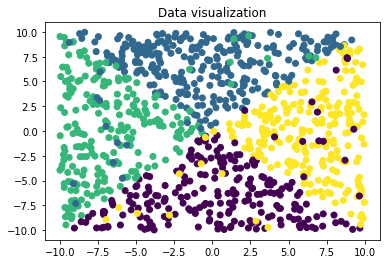

In [3]:
np.random.seed(1)

# On va générer 1000 exemples, avec 50 erreurs (volontaires)
m = 1000
noisy_count = 50

x_train = np.random.rand(m, 2) * 20 - 10
y_train = np.zeros((m,1))
y_train[np.where(np.all([x_train[:,0] <= x_train[:,1], x_train[:,0] >= -x_train[:,1]], axis = 0))] = 1
y_train[np.where(np.all([x_train[:,0] <= x_train[:,1], x_train[:,0] < -x_train[:,1]], axis = 0))] = 2
y_train[np.where(np.all([x_train[:,0] > x_train[:,1], x_train[:,0] >= -x_train[:,1]], axis = 0))] = 3
y_train[m-noisy_count:, 0] = 3-y_train[m-noisy_count:, 0]
#0 : partie basse
#1 : partie haute
#2 : partie gauche
#3 : partie droite

plot.scatter(x_train[:, 0], x_train[:,1], c=y_train)
t = plot.title('Data visualization')

samples = np.array([[0,8],[8,0],[-8,0],[0,-8]])
probabilities = k_nearest_neighbours(x_train, y_train, samples, k=10, class_count=4)
maxs = np.max(probabilities, axis = 1)
target_classes = np.argmax(probabilities, axis = 1)
for i in range(samples.shape[0]):
    print('Point (%d, %d) has been identified to be in class %s with probability %d%%'%(
        samples[i, 0],
        samples[i, 1],
        ['bottom', 'top', 'left', 'right'][target_classes[i]],
        maxs[i]*100
    ))

Encore mieux qu'hier !

Alors il faut être clair : c'est typiquement le genre de problème où cette méthode est probablement la plus efficace ! Mais quant à reconnaitre des chiffres ... on y arrive (et spoiler : on ne sera pas déçu)

Par contre, même dans ce cas d'école, il y a un gros inconvénient : la durée d'évaluation augmente avec le nombre de données comme on l'a dit, et la preuve : tracer les limites du système va prendre bien plus de temps que la classification d'hier (et la taille de la grille pour le dessin est pourtant 25x plus petite...)

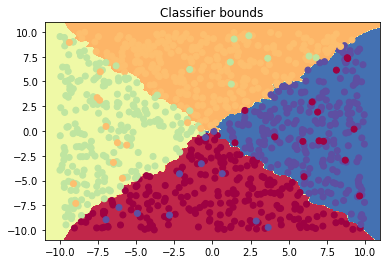

In [4]:
def plot_bounds(model, X, Y, draw_box):
    h=0.05
    mesh_x, mesh_y = np.meshgrid(
        np.arange(X[:,0].min() - 1, X[:,0].max() + 1, h),
        np.arange(X[:,1].min() - 1, X[:,1].max() + 1, h))
    Z = model(np.c_[mesh_x.ravel(), mesh_y.ravel()])
    Z = Z.reshape(mesh_x.shape)
    draw_box.contourf(mesh_x,mesh_y,Z, cmap=plot.cm.Spectral)
    draw_box.scatter(X[:,0], X[:,1], c=Y, cmap=plot.cm.Spectral)


plot.title('Classifier bounds')
plot_bounds(lambda x:np.argmax(k_nearest_neighbours(x_train, y_train, x, k=5, class_count = 4), axis = 1), x_train, y_train, plot)

## Retour à la mise en situation

### Chargement des données

Les données sont les même qu'hier. Elles proviennent du dataset de Yann Le Cun http://yann.lecun.com/exdb/mnist/

Il s'agit d'images 28x28 en noir et blanc, 60.000 données d'entrainement et 10.000 données de validation.

In [5]:
def load(file): 
    data = np.load(file)
    return data['x'], data['y']

x_train, y_train = load('data/d09_train_data.npz')
x_test , y_test  = load('data/d09_test_data.npz')

print('%i training samples loaded of size %i' %(x_train.shape[0], x_train.shape[1]))
print('%i test samples loaded' %(x_test.shape[0]))


60000 training samples loaded of size 784
10000 test samples loaded


On teste. Attention: c'est long...
* 10k tests
* avec pour chacun 60k distances euclidiennes
* sur des matrices de 28x28

$\rightarrow$ total: 470 milliards de multplications (sans parler du reste....)

On va plutôt prendre un sous ensemble ;) - prévoyez quand même quelques minutes...

In [6]:
x_test_small = x_test[:500,:]
y_test_small = y_test[:500,:]

#On calcule les résultats sur le jeu de test
test_results = np.argmax(k_nearest_neighbours(x_train, y_train, x_test_small, k = 10, class_count = 10), axis = 1).reshape(-1, 1)
print('Accuracy on test set (k = 10): %f' % (np.sum(test_results == y_test_small)/y_test_small.shape[0]))

Accuracy on test set (k = 10): 0.956000


On arrive donc, sans entrainement, à reconnaitre 95.6% des chiffres !!!

### Analyse des erreurs
Juste pour le fun : voilà les coupables

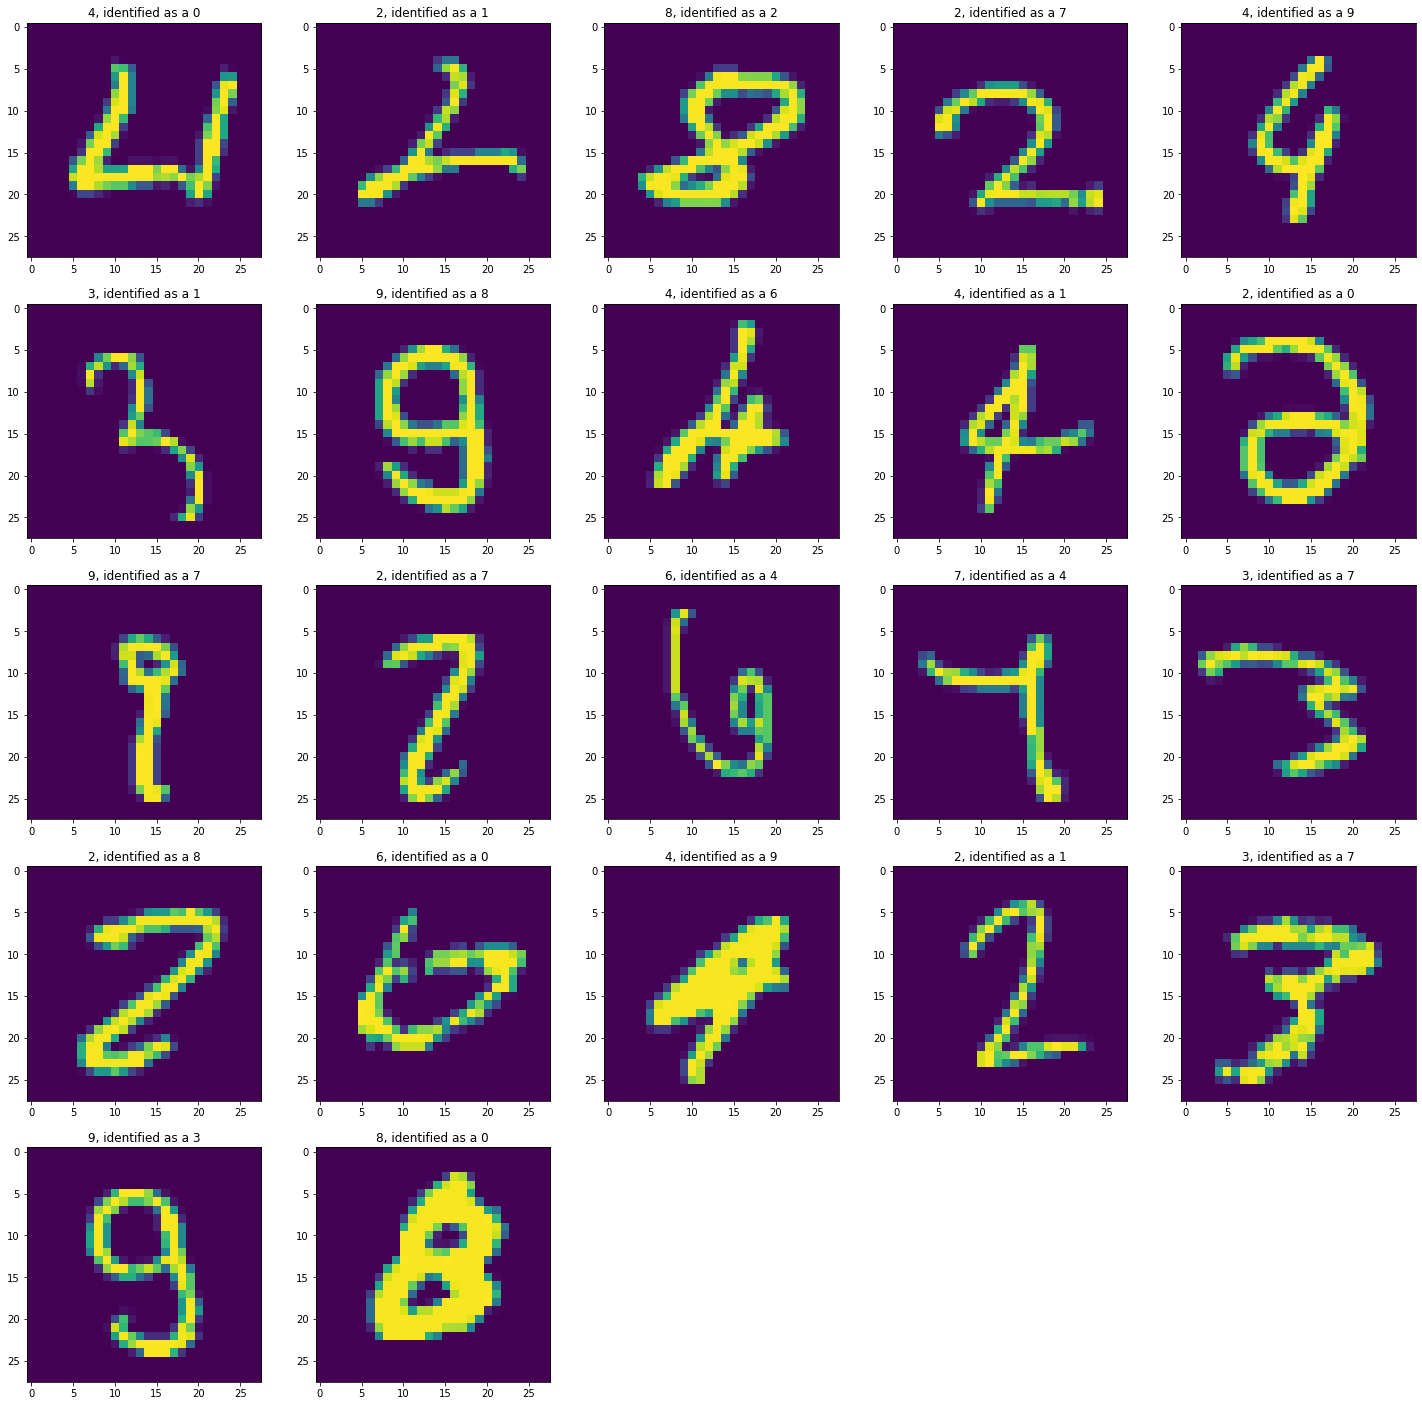

In [7]:
invalids = np.where(y_test_small != test_results)[0]
x_invalids = x_test_small[invalids,:].reshape(-1,28,28)
y_invalids = y_test_small[invalids]
test_results_invalids = test_results[invalids]
fig = plot.figure(figsize=(25,25))
for i in range(invalids.shape[0]):
    fig.add_subplot(5, 5, i+1)
    plot.imshow(x_invalids[i,:])
    plot.title('%i, identified as a %i'% (y_invalids[i], test_results_invalids[i]))

Bon franchement, y'a de quoi se tromper sur beaucoup d'entre eux :)

Mais alors si c'est si efficace, à quoi servent tous les autres modèles ? Plusieurs réponses : 

* D'abord, c'est pas forcément toujours efficace
* Ensuite, comme on peut le voir, c'est particulièrement lent... on peut quand même faire mieux que mon implémentation, notamment:
  * éviter le tri
  * interrompre le calcul des distances quand elle dépasse déjà les k plus proches
  * ...
* Enfin, c'est une méthode particulièrement vulnérable aux problèmes de classes mal distribuées

Un mot sur le dernier point, pour bien expliquer le souci : je souhaite par exemple prédire un diagnostique médical sur une maladie rare. Il y a (comme son nom l'indique) peu d'individus atteints par rapport aux individus sains : les k plus proches voisins seront à 99.99% des individus sains, à cause de la distribution de mes données.

Il existe quand même de nombreuses applications à ce modèle, qui comme on l'a vu est assez efficace malgré sa simplicité !

### Optimisation par compression des données
La durée d'évaluation dépend grandement de la taille de chaque donnée (ici 28x28 = 784).

D'ici quelques jours, on verra comment un algorithme _non supervisé_ permettra de choisir tout seul une manière de comprimer la donnée sur une taille plus restreinte (plus de 95% de gain !) tout en gardant des scores aussi élevés.